## Libraries and data import

In [54]:
import pandas as pd
import numpy as np
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
import tqdm
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
import multiprocessing
import spacy
nlp = spacy.load('en_core_web_md')
from spacy.tokens import DocBin
import json
import pandas as pd
import pickle
import numpy as np

In [55]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# Importing sklearn and TSNE.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
#from sklearn.utils.extmath import _ravel
# Random state we define this random state to use this value in TSNE which is a randmized algo.
RS = 25111993

# Importing matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# Importing seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [56]:
calib = pd.read_excel('tweets_train_hourly.xls')
predict = pd.read_excel('tweets_test_hourly.xls')

## Some exploration before deepdive

In [57]:
calib.head()
#calib.shape


,text,num,get_close_price,get_open_price,Open,Close,is_up,diff
0,"The fact that Sneaky Dianne Feinstein, who has...",2,2018-01-10 15:30:00+00:00,2018-01-10 14:30:00+00:00,2743.780029,2745.199951,1,1.419922
1,I want to thank my @Cabinet for working tirele...,1,2018-01-10 20:30:00+00:00,2018-01-10 19:30:00+00:00,2744.260010,2748.399902,1,4.139893
2,"Great news, as a result of our TAX CUTS &amp; ...",1,2018-01-11 15:30:00+00:00,2018-01-11 14:30:00+00:00,2753.959961,2757.239990,1,3.280029
3,"Today, it was my great honor to proclaim Janua...",1,2018-01-12 17:30:00+00:00,2018-01-12 16:30:00+00:00,2780.489990,2781.969971,1,1.479980
4,“President Donald J. Trump Proclaims January 1...,1,2018-01-16 19:30:00+00:00,2018-01-16 18:30:00+00:00,2790.080078,2781.530029,0,-8.550049


In [58]:
# How many words are there in the corpus? 

print(calib['text'].apply(lambda x: len(x.split(' '))).sum)

<bound method Series.sum of 0       87
1       41
2       13
3       42
4       13
5       16
6       39
7       39
8       25
9       43
10      42
11      32
12      17
13      60
14      10
15      50
16      31
17      32
18      68
19      26
20      45
21      19
22      42
23      28
24      36
25      39
26      48
27      44
28      82
29      13
      ... 
656    111
657     72
658     14
659    117
660     12
661     42
662    104
663     29
664     48
665    125
666     22
667     59
668     47
669    143
670     29
671     66
672     30
673     91
674     49
675    317
676     26
677    200
678     81
679    150
680     18
681     64
682     32
683     45
684     44
685     49
Name: text, Length: 686, dtype: int64>


In [59]:
# Creating an absolute difference feature

calib['absdiff'] = np.abs(calib['diff'])
impact_sorted = calib.sort_values(by=['absdiff'])

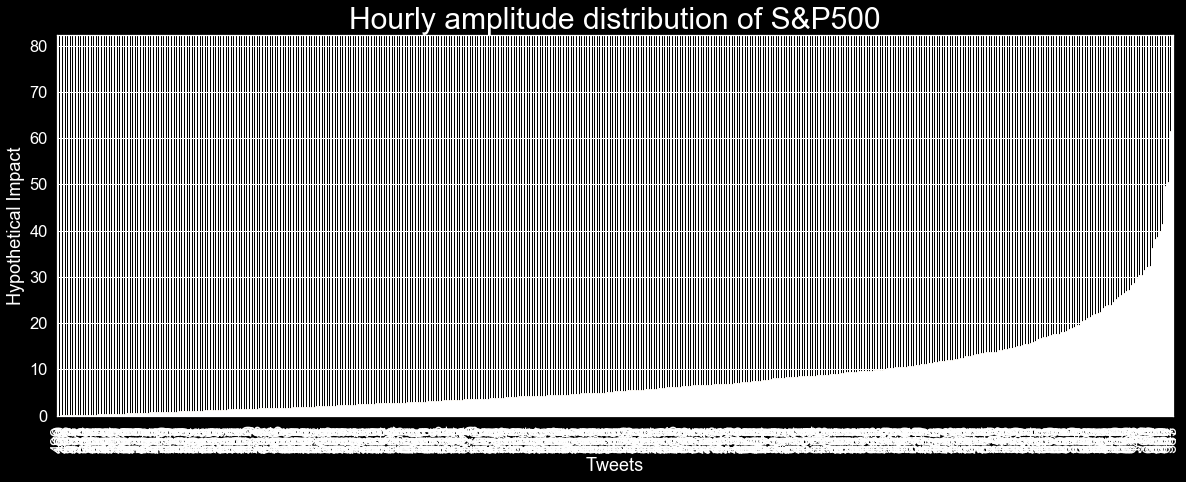

In [7]:
# Vizualizing the impact of certain tweets in the hour time window.

plt.style.use('dark_background')
impact_sorted['absdiff'].plot.bar(color = 'orange', figsize = (20, 7))
plt.title('Hourly amplitude distribution of S&P500', fontsize = 30, fontweight = 20)
plt.xlabel('Tweets')
plt.ylabel('Hypothetical Impact')
plt.show()

In [60]:
# In case we want to create a third class called 'Hold' to take out stationarity.
# This is in line with the basic three-way trading strategy: buy, hold or sell.

#large_impact = calib['absdiff'] < 2
#impact_tweets = calib[large_impact]
#impact_tweets.shape

In [61]:
# Minimum cleaning because we want the network to pick up on weak signals

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,}',r'',text)
    text = re.sub(r'[^\w\s]', r'',text)
    text = text.lower()
    return text
calib['text'] = calib['text'].apply(cleanText)

In [62]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
calib['text'] = calib['text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))

In [64]:
calib['text']

0      fact sneaky dianne feinstein numerous occasion...
1      want thank cabinet working tirelessly behalf c...
2                    great news result tax cuts jobs act
3      today great honor proclaim january 15 2018 mar...
4      president donald j trump proclaims january 16 ...
5      today honor welcome president nursultan nazarb...
6      departing pittsburgh great honor stand incredi...
7      whitehouse briefing director marc short direct...
8      today honored proud address 45th annual march_...
9      signed 702 bill reauthorize foreign intelligen...
10     earlier today spoke govmattbevin kentucky rega...
11     great bilateral meeting prime minister theresa...
12     productive bilateral meeting prime minister be...
13     heading back exciting two days davos switzerla...
14     congratulations americas new secretary hhsgov ...
15     35 million americans receiving bonuses benefit...
16     representative devin nunes man tremendous cour...
17     thanks historic tax cuts

In [65]:
# Train and test split on calibration set

train, test = train_test_split(calib, test_size=0.3, random_state=42)

In [66]:
# Removing stopwords using NLTK library and tagging every tweet with its is_up feature

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if word in stop:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.is_up]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.is_up]), axis=1)

In [67]:
train_tagged.values[30]

TaggedDocument(words=['long', 'open', 'eyes', 'gods', 'grace', 'open', 'hearts', 'gods', 'love', 'america', 'forever', 'land', 'free', 'home', 'brave', 'light', 'unto', 'nations', 'nationalprayerbreakfast'], tags=[0])

## tweet2vec Implementation

   ## Embedding 1: Distributed Bag-Of-Words (DBOW), with 300 dimensions
  

In [75]:
# Parallel computation

cores = multiprocessing.cpu_count()

In [76]:
# DBOW is the doc2vec model analogous to Skip-gram model in word2vec. Here, the tweet vectors are 
# obtained by training a neural network on the task of predicting a probability distribution of words 
# in a tweet given a randomly-sampled word from the tweet.

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in train_tagged.values])

In [77]:
# Training for 30 epochs


for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [78]:
# Building the final vector feature for the classifier

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [79]:
# Training a logistic regression classifier on the tweet embeddings

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.49514563106796117
Testing F1 score: 0.4950028555111365


C:\Users\Camille\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


   ## Embedding 2: Distributed Bag-Of-Words (DBOW), with 100 dimensions



In [73]:
# Parallel computation

cores = multiprocessing.cpu_count()

In [74]:
# DBOW is the doc2vec model analogous to Skip-gram model in word2vec. Here, the tweet vectors are 
# obtained by training a neural network on the task of predicting a probability distribution of words 
# in a tweet given a randomly-sampled word from the tweet.

model_dbow = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
vocab = model_dbow.build_vocab([x for x in train_tagged.values])

In [22]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [23]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [24]:
# Training a logistic regression classifier on the tweet embeddings

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.5048543689320388
Testing F1 score: 0.5041536911522256


C:\Users\Camille\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## 2D Vizualization of the tweet2vec embedding

In [26]:
X_train[0]

array([-1.3041142 ,  1.6852307 ,  0.02439253,  0.7871993 , -0.6486831 ,
       -0.9020322 , -0.3920117 ,  0.26028514, -1.1108752 , -0.26838714,
       -1.1405054 , -0.558525  ,  0.18773314,  1.3850808 ,  0.6814825 ,
        1.3816183 , -2.6903791 ,  2.2647963 , -1.3155439 ,  0.7288045 ,
        1.4541615 ,  0.31072065,  0.80605143,  1.5055206 , -0.30729473,
        0.25876018, -0.06995715, -1.0221038 ,  0.7138159 , -1.3615427 ,
       -1.7814566 ,  1.1195216 ,  1.8007581 , -0.55785197,  0.8291232 ,
        2.3691466 ,  0.6434749 ,  0.5004058 ,  1.2608157 , -1.2176979 ,
       -1.3067516 , -0.02081395,  0.89532876, -0.10945173, -0.19015624,
        0.00940914,  1.0116934 ,  1.5804046 , -0.8601055 , -0.37737846,
       -0.21777703, -1.0559887 , -1.7600206 , -1.4391136 ,  0.922785  ,
        0.16343722, -0.9885233 , -1.2779841 ,  1.86176   , -2.5590975 ,
        0.46452352,  0.02244454,  0.03972386,  0.5691938 , -1.1550741 ,
        1.0966337 ,  1.2642056 ,  1.8492587 ,  0.36617574,  0.65

In [50]:

# Tweet vector
Data_1 = X_train
#Clustering tweet vectors using K-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(Data_1)
# Extract labels from the 2 clusters
Y=kmeans.labels_ # a vector

z = pd.DataFrame(Y.tolist()) # a list
# Fit the model using t-SNE randomized algorithm
digits_proj = TSNE(random_state=RS).fit_transform(Data_1)

In [28]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("pastel", 2))

    # We create a scatter plot.
    f = plt.figure(figsize=(15,15))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=120,
                    c=y_train)
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    return f, ax, sc

(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.collections.PathCollection at 0x129fb0e78d0>)

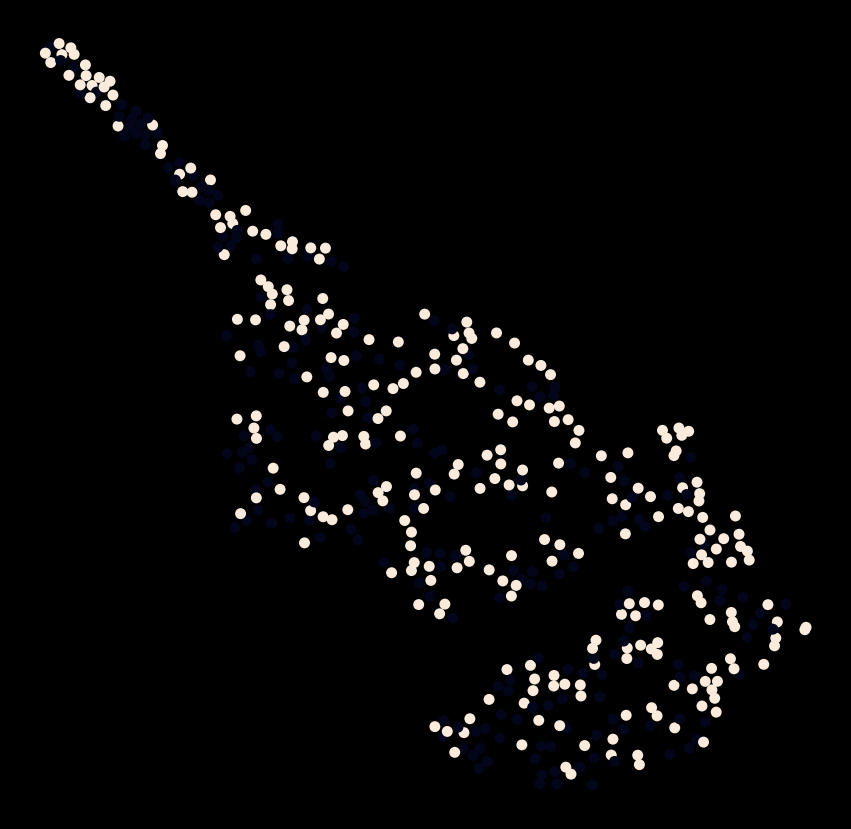

In [29]:
scatter(digits_proj, Y)

## 2D Visualization of word2vec similarity

In [30]:
model_dbow.init_sims(replace=True)

In [31]:
model_dbow.wv.most_similar(positive=["trump"])

[('tlaib', 0.31749629974365234),
 ('19', 0.3010846972465515),
 ('watching', 0.2847323715686798),
 ('speak', 0.27860647439956665),
 ('new', 0.2782982289791107),
 ('financial', 0.26986607909202576),
 ('choice', 0.26762813329696655),
 ('voice', 0.2669343948364258),
 ('japan', 0.26440322399139404),
 ('elizabeth', 0.25983726978302)]

In [32]:
model_dbow.wv.most_similar(positive=["taxes"])

[('behalf', 0.3701685667037964),
 ('treat', 0.37013936042785645),
 ('playing', 0.3668290078639984),
 ('open', 0.34657275676727295),
 ('entire', 0.3431015610694885),
 ('poll', 0.3322488069534302),
 ('congressional', 0.3245542049407959),
 ('center', 0.30859336256980896),
 ('game', 0.30245348811149597),
 ('thad', 0.30096882581710815)]

In [33]:
model_dbow.wv.most_similar(positive=["china"])

[('3', 0.3576483726501465),
 ('happen', 0.33074551820755005),
 ('approved', 0.2949331998825073),
 ('nuclear', 0.2840650677680969),
 ('contributor', 0.27572667598724365),
 ('ones', 0.27443742752075195),
 ('sovereignty', 0.2731100916862488),
 ('propaganda', 0.2684575319290161),
 ('unacceptable', 0.2671639919281006),
 ('prime', 0.2631761431694031)]

In [34]:
model_dbow.wv.most_similar(positive=["xi"])

[('path', 0.3267439603805542),
 ('though', 0.2982437014579773),
 ('powell', 0.2891514003276825),
 ('range', 0.282091349363327),
 ('investigators', 0.2615106701850891),
 ('hillary', 0.25843438506126404),
 ('outside', 0.25666701793670654),
 ('loss', 0.25574570894241333),
 ('deserve', 0.2532144784927368),
 ('weeks', 0.2470673769712448)]

In [35]:
model_dbow.wv.most_similar(positive=["president"])

[('asked', 0.315499871969223),
 ('vote', 0.2974526882171631),
 ('site', 0.29631662368774414),
 ('destruction', 0.28662407398223877),
 ('minnesota', 0.2742898464202881),
 ('focus', 0.2698882818222046),
 ('first', 0.25861024856567383),
 ('produced', 0.258356511592865),
 ('community', 0.2569296061992645),
 ('harry', 0.2496020644903183)]

In [36]:
model_dbow.wv.most_similar(positive=["wall"])

[('show', 0.3743143081665039),
 ('fishing', 0.32480013370513916),
 ('lgbt', 0.3154835104942322),
 ('cost', 0.2965424358844757),
 ('dropped', 0.2840539216995239),
 ('achievement', 0.2836153507232666),
 ('freedom', 0.2761473059654236),
 ('suspended', 0.2729125916957855),
 ('truth', 0.2655850648880005),
 ('beautiful', 0.26097434759140015)]

In [37]:
model_dbow.wv.most_similar(positive=["border"])

[('european', 0.32256054878234863),
 ('low', 0.3087417483329773),
 ('32', 0.3086298704147339),
 ('agency', 0.28929072618484497),
 ('release', 0.2799651026725769),
 ('trust', 0.2729429006576538),
 ('discussed', 0.2688581645488739),
 ('times', 0.2633498013019562),
 ('troy', 0.251463383436203),
 ('debbie', 0.24931442737579346)]

In [38]:
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [61]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=2).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    plt.rcParams['font.family'] = 'Yu Gothic'
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    lengend('color')
    
    plt.title('T-SNE visualization for {}'.format(word.title()))

In [ ]:
tsnescatterplot(model_dbow, 'trump', ['good', 'border', 'wall', 'hillary', 'french', 'xi', 'macron', 'president'])
plt.rcParams['font.family'] = 'Yu Gothic'

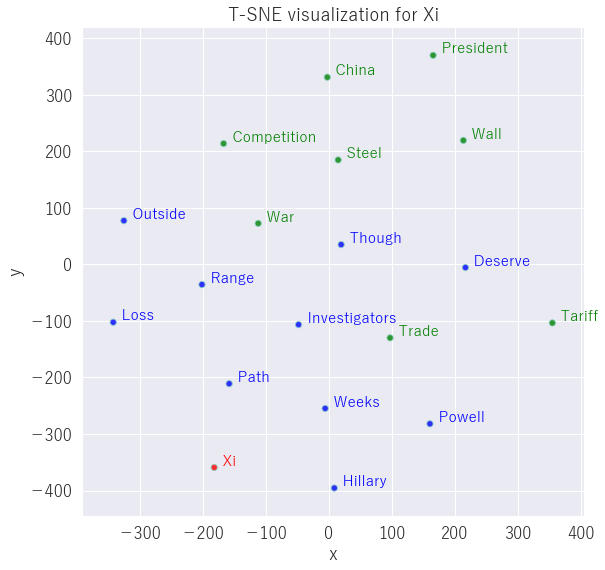

In [58]:
tsnescatterplot(model_dbow, 'xi', ['china', 'trade', 'wall', 'competition', 'war', 'tariff', 'steel', 'president'])
plt.rcParams['font.family'] = 'Yu Gothic'

## Embedding 2: Distributed Memory (DM)

In [80]:
#Distributed Memory (DM) acts as a memory that remembers what is missing from the current context
# — or as the topic of the paragraph. While the word vectors represent the concept of a word, the 
#tweet vector intends to represent the concept of a tweet. 
from tqdm import tqdm
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)

#model_dmm = Doc2Vec(dm=1, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|████████████████████████████████████████████████████████████████████████████| 480/480 [00:00<00:00, 480378.41it/s]


In [81]:
%%time
from tqdm import tqdm 
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|████████████████████████████████████████████████████████████████████████████████████████| 480/480 [00:00<?, ?it/s]


Wall time: 2.02 s


In [82]:
# Training the logistic on DM features

y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.5388349514563107
Testing F1 score: 0.5375610449357202


C:\Users\Camille\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Model pairing: combining DBOW and DM

In [83]:
# Delete previous training to free up RAM space

model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [84]:
# Concatenate DBOW and DM embeddings

from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [85]:
# Building feature vectors

def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [86]:
# Train the logistic classifier 

y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)
model = logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.5436893203883495
Testing F1 score: 0.5433450973391375


C:\Users\Camille\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [49]:
# Concatenating the two models improved the accuracy by 6% but this is still not enough.
# Steps for improvement: 
    # Train the embeddings on the whole calibration set, not only train. 
    # Reduce feature vector length from 300 to 100 
    # Use another classification model than logistic. 
    # Add the 'Hold' class to potentially improve lift score, 
        # even if adding a third class is conditionned to having more data. 